# OUTLINE

0. 小組成員  
1. Our code  
2. Model pre-train描述  
3. Model building描述  
4. 嘗試失敗的方法、code、與心得

## 0. 小組成員

106024518 張家豪  
105024701 李漢岳  
106024521 黃信恩

## 1. Our code

### 1.1 Data Pre-processing

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [24]:
training_data_file = open("data/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)
    
common_params = {
    'image_size': 224,
    'batch_size': 16,
    'num_classes': 20,
    'max_objects_per_image': 20
}
# voc
dataset_params = {
    'path': 'data/pascal_voc_training_data.txt',
    'image_dir': 'data_/JPEGImages/',
    'thread_num': 5
}
# coco
#dataset_params = {
#    'path': 'annotations/val2014.txt',
#    'image_dir': 'val2014/',
#    'thread_num': 5
#}

net_params = {
    'weight_decay': 0.0005,
    'cell_size': 7,
    'boxes_per_cell': 2,
    'object_scale': 1,
    'noobject_scale': 0.5,
    'class_scale': 1,
    'coord_scale': 5, 
    'moment_decay' : 0.9
}

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [25]:
import os
import math
import random
import cv2
import numpy as np
import tensorflow as tf
import re
import sys
import time

#if you have multiple GPU on the machine, choose only one to use on this notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#let the gpu allocates memory space dynamically
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
class DatasetRunner:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, common_params, dataset_params):
        
        self.width = common_params['image_size']
        self.height = common_params['image_size']
        self.batch_size = common_params['batch_size']
        self.num_classes = common_params['num_classes']
        self.data_path = dataset_params['path']
        self.thread_num = dataset_params['thread_num']
        self.image_dir = dataset_params['image_dir']
        
        self.max_objects = common_params['max_objects_per_image']
            
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph, config=config)
        
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(self.data_path, 'r')
        
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, self.max_objects))
            if len(self.record_list[-1])<self.max_objects*5:
                self.record_list[-1] = self.record_list[-1] +\
                [float(0), float(0), float(0), float(0), float(0)]*\
                (self.max_objects-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1])>self.max_objects*5:
                self.record_list[-1] = self.record_list[-1][:self.max_objects*5]

        self.build_train_data_tensor()
            
    def build_train_data_tensor(self):
        
        def data_generator(image_name, raw_labels, object_num):
            image_file = tf.read_file(self.image_dir+image_name)
            image = tf.image.decode_jpeg(image_file, channels=3)

            h = tf.shape(image)[0]
            w = tf.shape(image)[1]

            width_rate = self.width * 1.0 / tf.cast(w, tf.float32) 
            height_rate = self.height * 1.0 / tf.cast(h, tf.float32) 

            image = tf.image.resize_images(image, size=[self.height,self.width])
            
            raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
            
            xmin = raw_labels[:, 0]
            ymin = raw_labels[:, 1]
            xmax = raw_labels[:, 2]
            ymax = raw_labels[:, 3]
            class_num = raw_labels[:, 4]
            
            xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
            ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate
            
            box_w = (xmax - xmin) * width_rate
            box_h = (ymax - ymin) * height_rate
            
            labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

            return image, labels, tf.cast(object_num, tf.int32)
            

        with self.graph.as_default():
            
            dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                          np.array(self.record_list), 
                                                          np.array(self.object_num_list)))

            dataset = dataset.map(data_generator, num_parallel_calls = self.thread_num)
            dataset = dataset.shuffle(len(self.record_list)) 

            dataset = dataset.batch(self.batch_size)
            dataset = dataset.repeat()

            self.iterator = tf.data.Iterator.from_structure(dataset.output_types)  
            self.data_init_op = self.iterator.make_initializer(dataset)

            self.sess.run(self.data_init_op)
            self.iterate_op = self.iterator.get_next()
            
    def batch(self):
        images, labels, objects_num = self.sess.run(self.iterate_op)

        if objects_num.shape[0] < self.batch_size:
            images, labels, objects_num = self.sess.run(self.iterate_op)
        
        images = images/255 * 2 - 1
        
        return images, labels, objects_num
        
        
    def __del__(self):
        self.close()

    def close(self):

        self.sess.close()
        

## 1.2 Model building

In [27]:
class YoloTinyNet(object):

    def __init__(self, common_params, net_params, test=False):
        """
        common params: a params dict
        net_params   : a params dict
        """
        #pretrained variable collection
        self.pretrained_collection = []
        #trainable variable collection
        self.trainable_collection = []
        self.moment_decay = float(net_params['moment_decay'])
        self.weight_decay = net_params['weight_decay']
        self.cell_size = net_params['cell_size']
        self.height = common_params['image_size']
        self.batch_size = common_params['batch_size']
        self.num_classes = common_params['num_classes']
        self.data_path = dataset_params['path']
        self.thread_num = dataset_params['thread_num']
        self.image_dir = dataset_params['image_dir']
        self.boxes_per_cell = net_params['boxes_per_cell']
        self.image_size = common_params['image_size']
         
        self.max_objects = common_params['max_objects_per_image']
        
        if not test:
            self.object_scale = float(net_params['object_scale'])
            self.noobject_scale = float(net_params['noobject_scale'])
            self.class_scale = float(net_params['class_scale'])
            self.coord_scale = float(net_params['coord_scale'])
         
    def _variable_on_cpu(self, name, shape, initializer, pretrain=True, train=True):
        """Helper to create a Variable stored on CPU memory.
        Args:
          name: name of the Variable
          shape: list of ints
          initializer: initializer of Variable
        Returns:
          Variable Tensor
        """
        with tf.device('/cpu:0'):
            var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
            if pretrain:
                self.pretrained_collection.append(var)
            if train:
                self.trainable_collection.append(var)
        return var 
    
    def _variable_with_weight_decay(self, name, shape, stddev, wd=0.0, pretrain=True, train=True):
        """Helper to create an initialized Variable with weight decay.
        Note that the Variable is initialized with truncated normal distribution
        A weight decay is added only if one is specified.
        Args:
          name: name of the variable 
          shape: list of ints
          stddev: standard devision of a truncated Gaussian
          wd: add L2Loss weight decay multiplied by this float. If None, weight 
          decay is not added for this Variable.
       Returns:
          Variable Tensor 
        """
        var = self._variable_on_cpu(name, shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32), pretrain, train)
        if wd is not None:
            weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
            tf.add_to_collection('losses', weight_decay)
        return var 

    def fully(self, scope, input, in_dimension, out_dimension, leaky=True, pretrain=True, train=True):
        """Fully connection layer
        Args:
          scope: variable_scope name
          input: [batch_size, ???]
          out_dimension: int32
        Return:
          output: 2-D tensor [batch_size, out_dimension]
        """
        with tf.variable_scope(scope) as scope:
            reshape = tf.reshape(input, [tf.shape(input)[0], -1])

            weights = self._variable_with_weight_decay('weights', shape=[in_dimension, out_dimension],
                                  stddev=0.04, wd=self.weight_decay, pretrain=pretrain, train=train)
            biases = self._variable_on_cpu('biases', [out_dimension], tf.constant_initializer(0.0), pretrain, train)
            local = tf.matmul(reshape, weights) + biases

            if leaky:
                local = self.leaky_relu(local)
            else:
                local = tf.identity(local, name=scope.name)

        return local
    
    def leaky_relu(self, x, alpha=0.1, dtype=tf.float32):
        """leaky relu 
        if x > 0:
          return x
        else:
          return alpha * x
        Args:
          x : Tensor
          alpha: float, the slope of the leaky function
        Return:
          y : Tensor
        """
        x = tf.cast(x, dtype=dtype)
        
        return tf.nn.leaky_relu(x, alpha=alpha)
    
    def batch_norm(self,inp,name,train = True , eps = 1e-05 , decay=.9):
        
        with tf.variable_scope(name):
            params_shape = inp.shape.as_list()[-1:]
            beta  = tf.get_variable('beat', params_shape,initializer=tf.constant_initializer(0),dtype=tf.float32)
            gamma = tf.get_variable('gamma',params_shape,initializer=tf.constant_initializer(1),dtype=tf.float32)
            
            batch_mean,batch_var = tf.nn.moments(inp,[0,1,2],name='moments')
            ema = tf.train.ExponentialMovingAverage(decay)
            
            def mean_var_update():
                ema_apply_op = ema.apply([batch_mean,batch_var])
                with tf.control_dependencies([ema_apply_op]):
                    return(tf.identity(batch_mean),tf.identity(batch_var))
                
            mean ,var = tf.cond(tf.equal(train,True),mean_var_update,
                                lambda:(ema.average(batch_mean),ema.average(batch_var)))
            #if train:
            #    mean,var = mean_var_update()
            #else:
            #    mean = ema.average(batch_mean);var=ema.average(batch_var)
            
            return(tf.nn.batch_normalization(inp,mean,var,beta,gamma,eps))
        
    def conv_block(self,inp,scope,kernel_width,kernel_height,inp_channel,out_channel,
                   strides=[1,1,1,1],padding='SAME',bn=False,activation=True,is_biases = False):
        """ Convolution Layer + Batch Normalization + Leaky Relu
        Args:
           input : [batch_size,?,?,inp_channel]
        Return:
           local : [batch_size,kernel_width,kernel_height,out_channel]
        """
        with tf.variable_scope(scope):
            kernel = self._variable_with_weight_decay('weights',[kernel_width,kernel_height,inp_channel,out_channel],
                                                             stddev=5e-2)
            local = tf.nn.conv2d(inp,kernel,strides=strides,padding=padding)
            if is_biases:
                biases = self._variable_on_cpu('bias',[out_channel],tf.constant_initializer(0.0))
                local = tf.nn.bias_add(local,biases)
            if bn :
                local = self.batch_norm(local,'BN',train=True,decay = self.moment_decay)
            if activation:
                local = self.leaky_relu(local)
            return(local)
    
    
    def inference(self, images):
        """Build the yolo model
        Input the images, output prediction boxes(center_x, center_y, w, h, scale) and the corresponding classes
        
        Args:
          images:  4-D tensor [batch_size, image_height, image_width, channels]
        Returns:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        """
        net = self.conv_block(images,'conv_1',3,3,3,32,padding='SAME',activation=True)
        net = tf.nn.max_pool(net,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_1')
        
        net = self.conv_block(net,'conv_2',3,3,32,64,padding='SAME',activation=True)
        net = tf.nn.max_pool(net,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_2')
        
        net = self.conv_block(net,'conv_3_1',3,3,64,128,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_3_2',1,1,128,64,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_3_3',3,3,64,128,padding='SAME',activation=True)
        net = tf.nn.max_pool(net,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_3')
        
        net = self.conv_block(net,'conv_4_1',3,3,128,256,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_4_2',1,1,256,128,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_4_3',3,3,128,256,padding='SAME',activation=True)
        net = tf.nn.max_pool(net,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_4')
        
        net = self.conv_block(net,'conv_5_1',3,3,256,512,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_5_2',1,1,512,256,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_5_3',3,3,256,512,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_5_4',1,1,512,256,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_5_5',3,3,256,512,padding='SAME',activation=True)
        net = tf.nn.max_pool(net,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_5')
        
        net = self.conv_block(net,'conv_6_1',3,3,512,1024,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_6_2',1,1,1024,512,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_6_3',3,3,512,1024,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_6_4',1,1,1024,512,padding='SAME',activation=True)
        net = self.conv_block(net,'conv_6_5',3,3,512,1024,padding='SAME',activation=True)
        
        net = tf.reshape(net,[self.batch_size,-1])
        
        fully0 = self.fully('local0',net,7*7*1024,256)
        fully1 = self.fully('local1',fully0,256,512)
        fully2 = self.fully('local2',fully1,512,4096)
        fully3 = self.fully('local3',fully2,4096,self.cell_size*self.cell_size*
                            (self.num_classes+self.boxes_per_cell*5),leaky=False,pretrain=False,
                           train=True)
        n1 = self.cell_size**2*self.num_classes
 
        n2 = n1 + self.cell_size * self.cell_size * self.boxes_per_cell

        class_probs = tf.reshape(fully3[:, 0:n1], (-1, self.cell_size, self.cell_size, self.num_classes))
        scales = tf.reshape(fully3[:, n1:n2], (-1, self.cell_size, self.cell_size, self.boxes_per_cell))
        boxes = tf.reshape(fully3[:, n2:], (-1, self.cell_size, self.cell_size, self.boxes_per_cell * 4))

        predicts = tf.concat([class_probs, scales, boxes], 3)

        return predicts

    def iou(self, boxes1, boxes2):
        """calculate ious
        Args:
          boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
          boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)
          
        Return:
          iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        """
        
        #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
        boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                          boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])
        
        #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
        boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

        boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                          boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

        #calculate the left up point of boxes' overlap area
        lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
        #calculate the right down point of boxes overlap area
        rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

        #intersection
        intersection = rd - lu 

        #the size of the intersection area
        inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]
        
        mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

        #if intersection is negative, then the boxes don't overlap
        inter_square = mask * inter_square

        #calculate the boxs1 square and boxs2 square
        square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
        square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

        return inter_square/(square1 + square2 - inter_square + 1e-6)


    def losses_calculation(self, num, object_num, loss, predict, labels, nilboy):
        """
        calculate loss
        Args:
          predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
          labels : [max_objects, 5]  (x_center, y_center, w, h, class)
        """
        label = labels[num:num+1, :]
        label = tf.reshape(label, [-1])

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        min_x = (label[0] - label[2] / 2) / (self.image_size / self.cell_size)
        max_x = (label[0] + label[2] / 2) / (self.image_size / self.cell_size)

        min_y = (label[1] - label[3] / 2) / (self.image_size / self.cell_size)
        max_y = (label[1] + label[3] / 2) / (self.image_size / self.cell_size)

        min_x = tf.floor(min_x)
        min_y = tf.floor(min_y)

        max_x = tf.minimum(tf.ceil(max_x), self.cell_size)
        max_y = tf.minimum(tf.ceil(max_y), self.cell_size)

        temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
        objects = tf.ones(temp, tf.float32)

        temp = tf.cast(tf.stack([min_y, self.cell_size - max_y, min_x, self.cell_size - max_x]), tf.int32)
        temp = tf.reshape(temp, (2, 2))
        objects = tf.pad(objects, temp, "CONSTANT")

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
        center_x = label[0] / (self.image_size / self.cell_size)
        center_x = tf.floor(center_x)

        center_y = label[1] / (self.image_size / self.cell_size)
        center_y = tf.floor(center_y)

        response = tf.ones([1, 1], tf.float32)

        temp = tf.cast(tf.stack([center_y, self.cell_size - center_y - 1, 
                                 center_x, self.cell_size -center_x - 1]), 
                       tf.int32)
        self.tmp = tf.stack([center_y, self.cell_size - center_y - 1, 
                             center_x, self.cell_size -center_x - 1])
        temp = tf.reshape(temp, (2, 2))
        response = tf.pad(response, temp, "CONSTANT")
        #objects = response

        #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        predict_boxes = predict[:, :, self.num_classes + self.boxes_per_cell:]

        predict_boxes = tf.reshape(predict_boxes, [self.cell_size, 
                                                   self.cell_size, 
                                                   self.boxes_per_cell, 4])

        predict_boxes = predict_boxes * [self.image_size / self.cell_size, 
                                         self.image_size / self.cell_size, 
                                         self.image_size, self.image_size]

        base_boxes = np.zeros([self.cell_size, self.cell_size, 4])

        #for each cell
        for y in range(self.cell_size):
            for x in range(self.cell_size):
                
                base_boxes[y, x, :] = [self.image_size / self.cell_size * x, self.image_size / self.cell_size * y, 0, 0]
                
        base_boxes = np.tile(np.resize(base_boxes, [self.cell_size, self.cell_size, 1, 4]), [1, 1, self.boxes_per_cell, 1])

        #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
        predict_boxes = base_boxes + predict_boxes

        iou_predict_truth = self.iou(predict_boxes, label[0:4])
        #calculate C [cell_size, cell_size, boxes_per_cell]
        C = iou_predict_truth * tf.reshape(response, [self.cell_size, self.cell_size, 1])

        #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        I = iou_predict_truth * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        max_I = tf.reduce_max(I, 2, keep_dims=True)

        I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        no_I = tf.ones_like(I, dtype=tf.float32) - I 


        p_C = predict[:, :, self.num_classes:self.num_classes + self.boxes_per_cell]

        #calculate truth x, y, sqrt_w, sqrt_h 0-D
        x = label[0]
        y = label[1]

        sqrt_w = tf.sqrt(tf.abs(label[2]))
        sqrt_h = tf.sqrt(tf.abs(label[3]))

        #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        p_x = predict_boxes[:, :, :, 0]
        p_y = predict_boxes[:, :, :, 1]

        #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
        #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
        #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
        #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
        #p_sqrt_w = predict_boxes[:, :, :, 2]
        #p_sqrt_h = predict_boxes[:, :, :, 3]
        p_sqrt_w = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
        p_sqrt_h = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))
        
        #calculate truth p 1-D tensor [NUM_CLASSES]
        P = tf.one_hot(tf.cast(label[4], tf.int32), self.num_classes, dtype=tf.float32)

        #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
        p_P = predict[:, :, 0:self.num_classes]

        #class_loss
        class_loss = tf.nn.l2_loss(tf.reshape(objects, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale
        #class_loss = tf.nn.l2_loss(tf.reshape(response, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale

        #object_loss
        object_loss = tf.nn.l2_loss(I * (p_C - C)) * self.object_scale
        #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * self.object_scale

        #noobject_loss
        #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * self.noobject_scale
        noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * self.noobject_scale

        #coord_loss
        coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_y - y)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/ self.image_size +
                     tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/self.image_size) * self.coord_scale

        nilboy = I

        return (num + 1, object_num, [loss[0] + class_loss, 
                                      loss[1] + object_loss, 
                                      loss[2] + noobject_loss,
                                      loss[3] + coord_loss], 
                predict, labels, nilboy)

    def loss(self, predicts, labels, objects_num):
        """Add Loss to all the trainable variables
          Args:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
          ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
          labels  : 3-D tensor of [batch_size, max_objects, 5]
          objects_num: 1-D tensor [batch_size]
        """
        def condition(num, object_num, loss, predict, label, nilboy):
            """
            if num < object_num
            """
            return num < object_num
        
        class_loss = tf.constant(0, tf.float32)
        object_loss = tf.constant(0, tf.float32)
        noobject_loss = tf.constant(0, tf.float32)
        coord_loss = tf.constant(0, tf.float32)
        loss = [0, 0, 0, 0]
        for i in range(self.batch_size):
            predict = predicts[i, :, :, :]
            label = labels[i, :, :]
            object_num = objects_num[i]
            nilboy = tf.ones([7,7,2])
            tuple_results = tf.while_loop(condition, self.losses_calculation, 
                                          [tf.constant(0), object_num, 
                                           [class_loss, object_loss, noobject_loss, coord_loss], 
                                           predict, label, nilboy])

            for j in range(4):
                loss[j] = loss[j] + tuple_results[2][j]
            nilboy = tuple_results[5]

        tf.add_to_collection('losses', (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size)

        tf.summary.scalar('class_loss', loss[0]/self.batch_size)
        tf.summary.scalar('object_loss', loss[1]/self.batch_size)
        tf.summary.scalar('noobject_loss', loss[2]/self.batch_size)
        tf.summary.scalar('coord_loss', loss[3]/self.batch_size)
        tf.summary.scalar('weight_loss', tf.add_n(tf.get_collection('losses')) 
                          - (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size )

        return tf.add_n(tf.get_collection('losses'), name='total_loss'), nilboy

In [28]:
class YoloRunner(object):

    def __init__(self, dataset, net, common_params, solver_params):
        #process params
        self.learning_rate = float(solver_params['learning_rate'])
        self.moment = float(solver_params['moment'])
        self.batch_size = int(common_params['batch_size'])
        self.height = int(common_params['image_size'])
        self.width = int(common_params['image_size'])
        self.max_objects = int(common_params['max_objects_per_image'])
        self.train_dir = str(solver_params['train_dir'])
        
        if not os.path.exists(self.train_dir):
            os.makedirs(self.train_dir)
        
        self.max_iterators = int(solver_params['max_iterators'])
        self.print_frequency = int(solver_params['print_frequency'])
        self.save_frequency = int(solver_params['save_frequency'])
        #
        self.dataset = dataset
        self.net = net
        #construct graph
        self.construct_graph()
        
    def _train(self):
        """Train model
        Create an optimizer and apply to all trainable variables.
        Args:
          total_loss: Total loss from net.loss()
          global_step: Integer Variable counting the number of training steps
          processed
        Returns:
          train_op: op for training
        """
        opt = tf.train.AdamOptimizer(self.learning_rate)
        grads = opt.compute_gradients(self.total_loss)
        apply_gradient_op = opt.apply_gradients(grads, global_step=self.global_step)

        return apply_gradient_op

    def construct_graph(self):
        # construct graph
        self.global_step = tf.Variable(0, trainable=False)
        
        self.images = tf.placeholder(tf.float32, (None, self.height, self.width, 3))
        self.labels = tf.placeholder(tf.float32, (None, self.max_objects, 5))
        self.objects_num = tf.placeholder(tf.int32, (None))

        self.predicts = self.net.inference(self.images)
        self.total_loss, self.nilboy = self.net.loss(self.predicts, self.labels, self.objects_num)
        tf.summary.scalar('loss', self.total_loss)
        self.train_op = self._train()

    def run(self):
                
        saver = tf.train.Saver(self.net.trainable_collection, write_version=tf.train.SaverDef.V2)
        init =  tf.global_variables_initializer()
        summary_op = tf.summary.merge_all()
        sess = tf.Session(config = config)
        sess.run(init)
        summary_writer = tf.summary.FileWriter(self.train_dir, sess.graph)

        for step in range(self.max_iterators):
            start_time = time.time()

            np_images, np_labels, np_objects_num = self.dataset.batch()

            _, loss_value, nilboy= sess.run([self.train_op, self.total_loss, self.nilboy], 
                                            feed_dict={self.images: np_images, 
                                                       self.labels: np_labels,
                                                       self.objects_num: np_objects_num})

            duration = time.time() - start_time

            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % self.print_frequency== 0:
                num_examples_per_step = self.dataset.batch_size
                examples_per_sec = num_examples_per_step / duration
                sec_per_batch = float(duration)

                format_str = ('step %d, loss = %.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (step, loss_value,
                                     examples_per_sec, sec_per_batch))

                sys.stdout.flush()
            if step % self.print_frequency == 0:
                summary_str = sess.run(summary_op, feed_dict={self.images: np_images, 
                                                              self.labels: np_labels, 
                                                              self.objects_num: np_objects_num})
                summary_writer.add_summary(summary_str, step)
            if step % self.save_frequency == 0:
                saver.save(sess, self.train_dir + '/model.ckpt', global_step=step)
        sess.close()

    def prepare_inference(self, model_version):
        saver = tf.train.Saver(self.net.trainable_collection)
        init =  tf.global_variables_initializer()
        
        self.sess = tf.Session(config = config)
        self.sess.run(init)
        
        saver.restore(self.sess, self.train_dir+'/model.ckpt-'+model_version)

            
    def make_one_prediction(self, images):

        prediction = self.sess.run(self.predicts, feed_dict= {self.images: images})
        
        return prediction

In [29]:
solver_params = {
    'learning_rate': 0.0001,
    'moment': 0.9,
    'max_iterators': 2000,
    'print_frequency': 100,
    'save_frequency' : 1000,
    'train_dir': 'models/yolo-like'
}

### 1.3 Training

In [31]:
# training
tf.reset_default_graph()
sys.path.append('./')

dataset = DatasetRunner(common_params, dataset_params)
net = YoloTinyNet(common_params, net_params)
model_runner = YoloRunner(dataset, net, common_params, solver_params)
#model_runner.prepare_inference(model_version='80000')
model_runner.run()

INFO:tensorflow:Restoring parameters from models/yolo-like/model.ckpt-80000
step 0, loss = 206.38 (0.4 examples/sec; 42.620 sec/batch)
step 100, loss = 33.29 (46.6 examples/sec; 0.343 sec/batch)
step 200, loss = 26.05 (75.5 examples/sec; 0.212 sec/batch)
step 300, loss = 27.84 (69.3 examples/sec; 0.231 sec/batch)
step 400, loss = 24.55 (80.1 examples/sec; 0.200 sec/batch)
step 500, loss = 22.76 (86.2 examples/sec; 0.186 sec/batch)
step 600, loss = 24.63 (61.1 examples/sec; 0.262 sec/batch)
step 700, loss = 20.67 (77.8 examples/sec; 0.206 sec/batch)
step 800, loss = 26.48 (62.9 examples/sec; 0.254 sec/batch)
step 900, loss = 24.53 (75.9 examples/sec; 0.211 sec/batch)
step 1000, loss = 24.83 (82.1 examples/sec; 0.195 sec/batch)
step 1100, loss = 22.06 (62.4 examples/sec; 0.256 sec/batch)
step 1200, loss = 26.07 (62.4 examples/sec; 0.256 sec/batch)
step 1300, loss = 24.84 (71.7 examples/sec; 0.223 sec/batch)
step 1400, loss = 22.30 (43.6 examples/sec; 0.367 sec/batch)
step 1500, loss = 24

### 1.4 Prediction

In [18]:
# predict
def process_predicts(predicts):
    """
    Process YOLO outputs into bou
    """
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (net_params['cell_size'], net_params['cell_size'], 1, 20))
    C = np.reshape(C, (net_params['cell_size'], net_params['cell_size'], net_params['boxes_per_cell'], 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (net_params['cell_size'], 
                             net_params['cell_size'], 
                             net_params['boxes_per_cell'], 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (common_params['image_size']/float(net_params['cell_size']))
    ycenter = (index[0] + ycenter) * (common_params['image_size']/float(net_params['cell_size']))

    w = w * common_params['image_size']
    h = h * common_params['image_size']

    xmin = xcenter - w/2.0
    
    if xmin<0:
        xmin =0
        
    ymin = ycenter - h/2.0
    
    if ymin<0:
        ymin=0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [19]:
tf.reset_default_graph()
common_params['batch_size'] = 1
net = YoloTinyNet(common_params, net_params)
solver = YoloRunner(None, net, common_params, solver_params)

In [20]:
test_img_files = open('data/pascal_voc_testing_data.txt')
test_img_dir = 'data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
img_size = common_params['image_size']

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])
    
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    
    image_file = tf.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize_images(image, size=[img_size,img_size])
    
    return image_name, image, h, w
test_dataset = test_dataset.map(load_img_data)
test_iterator = test_dataset.make_one_shot_iterator()
next_test_element = test_iterator.get_next()
tdata_sess = tf.Session(config = config)

In [21]:
output_file = open('data/test_predion_no_norm.txt', 'w')
solver.prepare_inference(model_version = '80000')

while True:
    try:
        img_name, test_img, img_h, img_w = tdata_sess.run(next_test_element)
        test_img = test_img/255 * 2 - 1
        test_img = np.expand_dims(test_img, axis=0)
        y_pred = solver.make_one_prediction(test_img)
        xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)

        xmin, ymin, xmax, ymax = xmin*(img_w/img_size), ymin*(img_h/img_size), xmax*(img_w/img_size), ymax*(img_h/img_size)

        #img filename, (xmin, ymin, xmax, ymax, class, confidence)*number_of_predictions
        output_file.write(img_name.decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
    except tf.errors.OutOfRangeError:
        print("done predicting all test data")
        break
output_file.close()

INFO:tensorflow:Restoring parameters from models/yolo-like/model.ckpt-80000
done predicting all test data


In [22]:
sys.path.insert(0, 'evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./data/test_predion_no_norm.txt', './output_file_v2.csv')

End Evalutation


### 1.5 Predict visualization

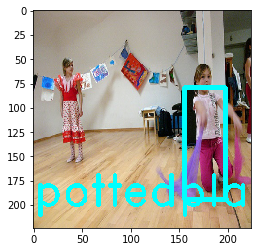

In [32]:
import cv2
np_img = cv2.imread('darknet/data/2007_000423.jpg')
resized_img = cv2.resize(np_img, (224, 224))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, 224,224, 3))

y_pred = solver.make_one_prediction(np_img)
xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)

## 2. Model pre-train描述  

1. 使用COCO dataset val2014 作為 pretrain data
2. 資料處理:  
   將coco 資料的bbox轉成VOCdata的形式  
   在class label有5個類別不一致, 找類似的label代替, 並移除掉多餘的60個label資料。  
3. 以下呈現Coco資料處理的code

In [ ]:
import pandas as pd
import numpy as np
import json

json_data1=open('instances_val2014.json').read()
data1 = json.loads(json_data1)

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

LABELS = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus',
          'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
          'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
          'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
          'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 
          'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
          'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 
          'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
          'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
          'teddy bear', 'hair drier', 'toothbrush']

image_id = np.zeros(len(data1['annotations']),dtype=int)
for i in range(len(data1['annotations'])):
    image_id[i] = int(data1['annotations'][i]['image_id'])


dd1 = np.zeros(80,dtype=int)
for i in range(80):
    dd1[i] = int(data1['categories'][i]['id'])

dd2 = []
for i in range(80):
    dd2.append(data1['categories'][i]['name'])

dic = dict(zip(dd2, dd1))
dic2 = dict(zip(dd1, range(80)))

qq1 = np.zeros(len(data1['annotations']),dtype=int)
qq2 = np.zeros(len(data1['annotations']),dtype=float)
qq3 = np.zeros(len(data1['annotations']),dtype=float)
qq4 = np.zeros(len(data1['annotations']),dtype=float)
qq5 = np.zeros(len(data1['annotations']),dtype=float)
qq6 = np.zeros(len(data1['annotations']),dtype=int)


for i in range(len(data1['annotations'])):
    if LABELS[dic2[data1['annotations'][i]['category_id']]] in classes_name:        
        qq1[i] = data1['annotations'][i]['image_id']
        qq2[i] = data1['annotations'][i]['bbox'][0]
        qq3[i] = data1['annotations'][i]['bbox'][1]
        qq4[i] = data1['annotations'][i]['bbox'][2]
        qq5[i] = data1['annotations'][i]['bbox'][3]
        qq6[i] = classes_name.index(LABELS[dic2[data1['annotations'][i]['category_id']]])


yi = pd.DataFrame({'image_id':qq1,'box1':qq2,'box2':qq3,
                   'box3':qq4,'box4':qq5,'class':qq6+1})
yi = yi.drop_duplicates().reset_index(drop=True).iloc[1:,:]
yi = yi.sort_values('image_id')
yi = yi.reset_index(drop=True)

# 轉換bbox
yi1 = yi.copy()
yi1.box1 = yi.box1
yi1.box2 = yi.box2
yi1.box3 = yi.box1+yi.box3
yi1.box4 = yi.box2+yi.box4

from itertools import chain
i = 0
a3=[]
while i < yi1.shape[0] :
    j = i+1
    a2 = [yi1.iloc[i,0]]
    a2.append( list(yi1.iloc[i,1:6]) )

    while yi1.iloc[i,0] == yi1.iloc[j,0]:
        a2.append(list(yi1.iloc[j,1:6]))
        j+=1
    i = j     
    a3.append([a2[0],list(chain(*a2[1:]))])


print(a3[1:5])

a4=[]
for i in range(len(a3)):
    if len(str(a3[i][0]))==5:
        name = 'COCO_val2014_0000000'+str(a3[i][0])+'.jpg'
    elif len(str(a3[i][0]))==6:
        name = 'COCO_val2014_000000'+str(a3[i][0])+'.jpg'
    elif len(str(a3[i][0]))==2:
        name = 'COCO_val2014_0000000000'+str(a3[i][0])+'.jpg'
    elif len(str(a3[i][0]))==3:
        name = 'COCO_val2014_000000000'+str(a3[i][0])+'.jpg'
    elif len(str(a3[i][0]))==4:
        name = 'COCO_val2014_00000000'+str(a3[i][0])+'.jpg'
    a4.append([name+' '+' '.join(str(e) for e in list(chain(*a3[i][1:])))])



with open('val2014.txt', 'w') as f:
    for item in list(chain(*a4)):
        f.write("%s \n" % item)

## 3. Model building描述

1. 使用yolo V1的loss function，搭配Yolo V2的DarkNet19 的架構
2. Optimizer使用Adam, batch size設定32, 訓練80000次(loss可以降到3左右)
3. 曾嘗試過batch normalization，但發現結果沒有比較好，因此最後沒選擇使用batch normalization

## 4. 嘗試失敗的方法、code、與心得

1. 我們嘗試自己設計 yolo v2 的model, 但是出現了 bug , 在時間截止之前也還未完全debug  
2. 迫於時間限制,使用了yolo v1 的model, 但是還是使用了 yolo v2 darknet 19 的網路設計  
3. 而我們也嘗試了googlenet的網路設計, 但是loss卻無法收斂。我們在想可能是我們選擇的optimization 與 一開始的初始值不好。  
4. 以下是我們設計的 loss calculation:  

```python

 def losses_calculation(self,num,object_num,loss,predict,labels,anchors,batch_step):
        """
        Args:
            labels : image of [max_objects,5] (x_center,y_center,w,h,class) ~ labels是resize後(0,1)
            num : the number of labels (iters)
            anchors: 預定 的 anchors 大小 [9,2]
            predict : 3-tensor [image_size/32 , image_size/32 , channel_dim ] (darknet19 的output)
        """
        
        ############## Feature Map Process ##############
        
        self.H,self.W = int(self.image_size//(32)) # 網格數(Cell size)        
        detection_result = tf.reshape(predict,[-1,H*W,self.num_anchors,num_classes+5]) 
        
        xy_offset = tf.nn.sigmoid(detection_result[:,:,0:2])  # xy center 偏移係數
        wh_offset = tf.exp(detection_result[:,:,2:4])         # wh 比例 指數縮放
        obj_p = tf.nn.sigmoid(detection_result[:,:,4])        # obj 幾率
        class_p = tf.nn.softmax(detection_result[:,:,5:])     # 每個 class的幾率
        
        height_index = tf.range(H,dtype=tf.float32) ; width_index = tf.range(W,dtype = tf.float32)
        x_cell,y_cell = tf.meshgrid(height_index,width_index)
        x_cell = tf.reshape(x_cell,[1,-1,1]) ; y_cell = tf.reshape(y_cell,[1,-1,1])
        
        bbox_x = (x_cell+xy_offset[:,:,0])/W
        bbox_y = (y_cell+xy_offset[:,:,1])/H
        bbox_w = (anchors[:,0]*wh_offset[:,:,0])/W
        bbox_h = (anchors[:,1]*wh_offset[:,:,1])/H
        
        # Back to [x_min,y_min,x_max,y_max] (scale to 0-1之間的value)
        # bboxes = tf.stack([bbox_x-bbox_w/2,bbox_y-bbox_h/2,bbox_x+bbox_w/2,bbox_y+bbox_h/2],axis=3)
        bboxes = tf.stack([bbox_x,bbox_y,bbox_w,bbox_h],axis=3)
        
        ####################### Loss Defn ##################################
        
        # 建立 truth 的 position
        label = labels[num:num+1,:]
        label = tf.reshape(label,[-1])
        
        ###### LOSS 1 : No obj loss ######
        # Counting the iou for each cell and Anchors
        iou = bboxes_iou(bboxes,label[0:4])
        
        # 判斷 max of Anchors for each Cell
        max_iou = tf.argmax(iou,axis = -1) # [H*W]
        max_mask = tf.one_hot(max_iou,self.num_anchors,dtype=tf.float32) # [H*W,Anchors]
        
        # 判斷 threshold of object probability for each Anchors
        threshold_mask = tf.cast(iou < self.threshold_obj,dtype=tf.float32) # [H*W,Anchors]
        
        # Total loss 
        #noobject_loss = tf.nn.l2_loss(max_mask*threshold_mask*obj_p)*self.noobject_scale
        
        ###### LOSS 2 : Coord loss ###### (同時定義 H,W方向)
        # 判斷哪個 anchors 與 truth 的 iou 最大
        label_center = tf.pad(label[2:],[[2,0]]) 
        anchors_center = tf.pad(anchors,[[0,0],[2,0]]) # anchors [5,2]
        anchors_center = tf.reshape(anchors_center,[1,self.num_anchors,4])
        iou_truth = bboxes_iou(anchors_center,label[0:4]) # 2-tensor [1,5]
        anchors_select = tf.argmax(iou_turth,-1)[0] # the anchors we want 
        
        # truth label 的 Coordinate
        label_x = tf.floor(label[0]*self.W) ; label_y = tf.floor(label[1]*self.H)
        truth_x = label[0]*self.W - label_x ; turth_y = label[1]*self.H - label_y # output格式
        truth_w = tf.log(label[2]/anchors[anchors_select,0]*self.W)
        truth_h = tf.log(label[3]/anchors[anchors_select,1]*self.H)
        
        truth_coord = tf.stack([truth_x,truth_y,truth_w,truth_h],axis=0)# 1-tensor [4]
        
        # Pred label 的 Coordinate
        pred_xy = xy_offset[label_x+(label_y-1)*(self.H),anchors_select,:] 
        pred_wh = detection_result[label_x+(label_y-1)*(self.H),anchors_select,2:4]
        pred_coord = tf.concat([pred_xy,pred_wh],axis=0) #  1-tensor [4]
        
        # Total loss
        #coord_loss = self.coord_scale*tf.nn.l2_loss(pred_coord-truth_coord)
        
        ######## LOSS 3 : Obj Loss ###########
        iou_obj = iou[label_x+(label_y-1)*(self.H),anchors_select] 
        obj_p_obj = obj_p[label_x+(label_y-1)*(self.H),anchors_select]
        # Total loss
        #object_loss = self.object_scale*tf.nn.l2_loss(iou_obj-obj_p_obj)
        
        ###### LOSS 4 : Class loss ###########
        truth_class = tf.one_hot(tf.cast(label[4],tf.int32),self.num_classes,dtype=tf.float32)
        # Total loss
        #class_loss = self.class_scale*tf.nn.l2_loss(truth_class-class_p[label_x+(label_y-1)*(self.H),anchors_select,:])
        
        ###### LOSS 5 : Prior Learn ############# 
        iter_12800 = tf.cast(batch_step<=12800,tf.int32)
        l1 = (xy_offset-0.5)
        prior_loss_func = tf.concat([l1,detection_result[:,:,2:4]],axis=-1)
        
        #################################################################
        maodun = tf.ones([1,1]) ; it = label_x+(label_y-1)*(self.H)
        temp = tf.cast(tf.stack([it,13*13-it-1,anchors_select,self.num_anchors-anchors_select-1]),tf.int32)
        temp = tf.reshape(temp,(2,2))
        maodun = tf.pad(maodun,temp,'CONSTANT')
    
        noobject_loss = self.noobject_scale*tf.nn.l2_loss(maodun*max_mask*threshold_mask*obj_p)
        coord_loss = self.coord_scale*tf.nn.l2_loss(pred_coord-truth_coord)
        object_loss = self.object_scale*tf.nn.l2_loss(iou_obj-obj_p_obj)
        class_loss = self.class_scale*tf.nn.l2_loss(truth_class-class_p[label_x+(label_y-1)*(self.H),anchors_select,:])
        prior_loss = self.prior_scale*tf.nn.l2_loss(iter_12800*prior_loss_func)
        
        #################### RETURN FK YOU ################################
        
        return(num+1,object_num,[loss[0]+class_loss,
                                loss[1]+object_loss,
                                loss[2]+noobject_loss,
                                loss[3]+coord_loss,
                                loss[4]+prior_loss],predict,labels,anchors,batch_step)
    
       ############################## END ########################################
        
    def loss(self,predicts,labels,objects_num,batch_step):
        """Add Loss to all the trainable variables
          Args:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
          ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
          labels  : 3-D tensor of [batch_size, max_objects, 5]
          objects_num: 1-D tensor [batch_size]
        """        
        def condition(num,object_num,loss, predict, label,anchors,batch_step):
            return (num < object_num)
        
        class_loss = tf.constant(0,tf.float32)
        object_loss = tf.constant(0,tf.float32)
        noobject_loss = tf.constant(0,tf.float32)
        coord_loss = tf.constant(0,tf.float32)
        loss = [0,0,0,0,0]
        for i in range(self.batch_size):
            predict = predicts[i,:,:,:] # 3-D tensor 
            label = labels[i,:,:]
            object_num = objects_num[i]
            tuple_results = tf.while_loop(condition,self.losses_calculation,
                                          [tf.constant(0),object_num,[class_loss, object_loss, noobject_loss, coord_loss,prior_loss],predict, label,self.anchors,batch_step])
            for j in range(5):
                loss[j] = loss[j] + tuple_results[2][j]
                                
        ################################## Setting graph ##########################
        tf.add_to_collection('losses',(loss[0]+loss[1]+loss[2]+loss[3])/self.batch_size)
        tf.summary.scalar('class_loss', loss[0]/self.batch_size)
        tf.summary.scalar('object_loss', loss[1]/self.batch_size)
        tf.summary.scalar('noobject_loss', loss[2]/self.batch_size)
        tf.summary.scalar('coord_loss', loss[3]/self.batch_size)
        tf.summary.scalar('prior_loss',loss[4]/self.batch_size)
        tf.summary.scalar('weight_loss', tf.add_n(tf.get_collection('losses')) 
                          - (loss[0] + loss[1] + loss[2] + loss[3]+loss[4])/self.batch_size )

        return(tf.add_n(tf.get_collection('losses'), name='total_loss'))

```
